# Recommendation engine
This notebook is inspired by the following articles:
- __Comprehensive Guide to build a Recommendation Engine from scratch (in Python)__  
https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-recommendation-engine-python/
- __Implementing your own recommender systems in Python__   
https://cambridgespark.com/content/tutorials/implementing-your-own-recommender-systems-in-Python/index.html

The goal is to get the hands on implementing a recommendation engine and understand their strenght, limitations and other subtilties.  
The following is to be considered as a summary of this article.

## Introduction
A recommendation engine filters the data using different algorithms and recommends the most relevant items to users. It first captures the past behavior of a customer and based on that, recommends products which the users might be likely to buy.

There are several ways to recommend items to users:
- We can recommend items to a user which are most popular among all the users
- We can divide the users into multiple segments based on their preferences (user features) and recommend items to them based on the segment they belong to

Both of the above methods have their drawbacks. In the first case, the most popular items would be the same for each user so everybody will see the same recommendations. While in the second case, as the number of users increases, the number of features will also increase. So classifying the users into various segments will be a very difficult task.

Let's explore each type of recommendation

## Content based filtering
This algorithm recommends products which are similar to the ones that a user has liked in the past.
Consider the example of Netflix. They save all the information related to each user in a vector form. This vector contains the past behavior of the user, i.e. the movies liked/disliked by the user and the ratings given by them. This vector is known as the profile vector. All the information related to movies is stored in another vector called the item vector. Item vector contains the details of each movie, like genre, cast, director, etc.

The content-based filtering algorithm finds the cosine of the angle between the profile vector and item vector, i.e. cosine similarity. Suppose A is the profile vector and B is the item vector, then the similarity between them can be calculated as:

$sim(A,B) = cos(\theta) = \frac{A.B}{||A||||B||}$

Based on the cosine value, which ranges between -1 to 1, the movies are arranged in descending order and one of the two below approaches is used for recommendations:

- Top-n approach: where the top n movies are recommended (Here n can be decided by the business)
- Rating scale approach: Where a threshold is set and all the movies above that threshold are recommended

Other methods that can be used to calculate the similarity are:
- Euclidean Distance
- Pearson’s Correlation

A major drawback of this algorithm is that it is limited to recommending items that are of the same type. It will never recommend products which the user has not bought or liked in the past. So if a user has watched or liked only action movies in the past, the system will recommend only action movies. It’s a very narrow way of building an engine.

To improve on this type of system, we need an algorithm that can recommend items not just based on the content, but the behavior of users as well.


## Collaborative filtering
The collaborative filtering algorithm uses “User Behavior” for recommending items. This is one of the most commonly used algorithms in the industry as it is not dependent on any additional information. There are different types of collaborating filtering techniques and we shall look at them in detail below.

### User-User collaborative filtering
This algorithm first finds the similarity score between users. Based on this similarity score, it then picks out the most similar users and recommends products which these similar users have liked or bought previously.  
In terms of our movies example from earlier, this algorithm finds the similarity between each user based on the ratings they have previously given to different movies. The prediction of an item for a user u is calculated by computing the weighted sum of the user ratings given by other users to an item i.

$$P_{u,i} = \frac{\sum_v r_{v,i}  s_{u,v}}{\sum_v s_{u,v}}$$

Here,

- $P_{u,i}$ is the prediction of an item
- $r_{v,i}$ is the rating given by a user v to a movie i
- $s_{u,v}$ is the similarity between users (Pearson correlation)

Following steps are followed to do so:

1. For predictions we need the similarity between the user u and v. We can make use of Pearson correlation.
1. First we find the items rated by both the users and based on the ratings, correlation between the users is calculated.
1. The predictions can be calculated using the similarity values. This algorithm, first of all calculates the similarity between each user and then based on each similarity calculates the predictions. Users having higher correlation will tend to be similar.
1. Based on these prediction values, recommendations are made. Let us understand it with an example:

### Item-Item collaborative filtering
In this algorithm, we compute the similarity between each pair of items.
We will find the similarity between each movie pair and based on that, we will recommend similar movies which are liked by the users in the past. This algorithm works similar to user-user collaborative filtering with just a little change – instead of taking the weighted sum of ratings of “user-neighbors”, we take the weighted sum of ratings of “item-neighbors”. The prediction is given by:

$$P_{u,i} = \frac{\sum_N s_{i,N} r_{u,N}}{\sum_N |s_{i,N}|}$$

with $s_{i,j} = cos(\vec i,\vec j) = \frac{\vec i . \vec j}{||\vec i||||\vec j||}$

### Side note on cold start
Before going further and implementing these concepts, there is a question which we must know the answer to – what will happen if a new user or a new item is added in the dataset? It is called a Cold Start. There can be two types of cold start:

- Visitor Cold Start
- Product Cold Start

Visitor Cold Start means that a new user is introduced in the dataset. Since there is no history of that user, the system does not know the preferences of that user. It becomes harder to recommend products to that user. So, how can we solve this problem? One basic approach could be to apply a popularity based strategy, i.e. recommend the most popular products. These can be determined by what has been popular recently overall or regionally. Once we know the preferences of the user, recommending products will be easier.

On the other hand, Product Cold Start means that a new product is launched in the market or added to the system. User action is most important to determine the value of any product. More the interaction a product receives, the easier it is for our model to recommend that product to the right user. We can make use of Content based filtering to solve this problem. The system first uses the content of the new product for recommendations and then eventually the user actions on that product.

# Implementation 

We will download the MovieLens dataset (http://grouplens.org/datasets/movielens/100k/). We focus only on a subpart of the whole MovieLensdataset (100,000 ratings from 1000 users on 1700 movies).

Documentation about the dataset can be found here: http://files.grouplens.org/datasets/movielens/ml-100k-README.txt

## Loading the data

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.options.display.max_columns = 50

In [2]:
#Reading users file:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols, encoding='latin-1')

#Reading ratings file:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols, encoding='latin-1')

#Reading items file:
i_cols = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
items = pd.read_csv('ml-100k/u.item', sep='|', names=i_cols, encoding='latin-1')


In [3]:
print(users.shape)
users.head()

(943, 5)


,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [4]:
print(ratings.shape)
ratings.head()

(100000, 4)


,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [7]:
print(items.shape)
items.head()

(1682, 24)


,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


## Building the collaborative filtering model

Before going further, let's calculate the sparsity level of MovieLens dataset:

In [38]:
sparsity = round(1.0-len(ratings)/float(n_users*n_items),3)
print('The sparsity level of MovieLens100K is ' +  str(sparsity*100) + '%')

The sparsity level of MovieLens100K is 93.7%


In [12]:
n_users = ratings.user_id.unique().shape[0]
n_items = ratings.movie_id.unique().shape[0]

Let's create two user-item matrices, one for training and another for testing

In [46]:
from sklearn.model_selection import train_test_split
ratings_train, ratings_test = train_test_split(ratings, test_size=0.25)

In [72]:
train_data_matrix = np.zeros((n_users, n_items))
for line in ratings_train.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]

test_data_matrix = np.zeros((n_users, n_items))
for line in ratings_test.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

Now, we will calculate the similarity. We can use the pairwise_distance function from sklearn to calculate the cosine similarity.

In [15]:
from sklearn.metrics.pairwise import pairwise_distances 
user_similarity = pairwise_distances(data_matrix, metric='cosine')
item_similarity = pairwise_distances(data_matrix.T, metric='cosine')

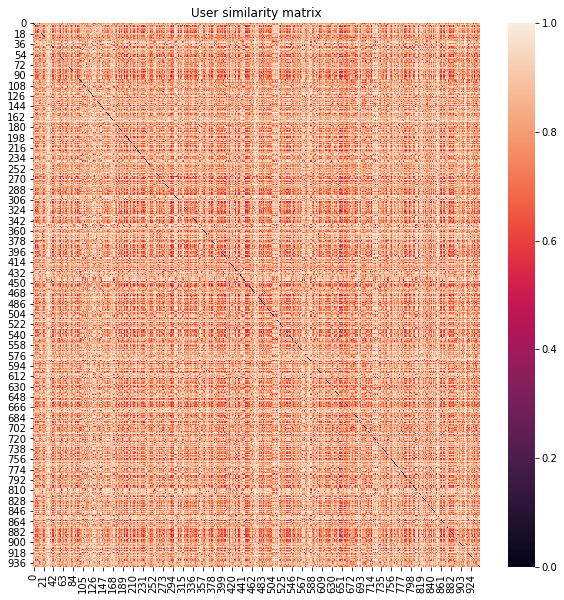

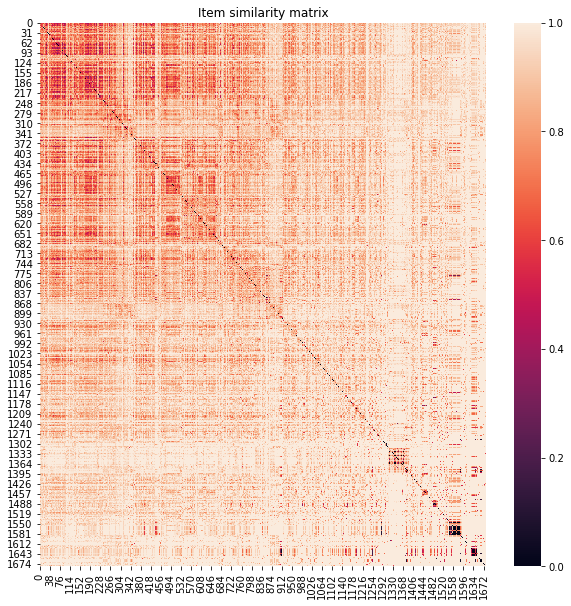

In [65]:
import seaborn as sns

plt.figure(figsize=(10,10))
plt.title("User similarity matrix")
sns.heatmap(user_similarity)
plt.show()

plt.figure(figsize=(10,10))
plt.title("Item similarity matrix")
sns.heatmap(item_similarity)
plt.show()


 The next step is to make predictions based on these similarities. Let’s define a function to do just that.

In [21]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #We use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred


In [22]:
user_prediction = predict(train_data_matrix, user_similarity, type='user')
item_prediction = predict(train_data_matrix, item_similarity, type='item')

### Evaluation

In [68]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [69]:
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 2.954736821503665
Item-based CF RMSE: 3.382384879768012


In [82]:
r = pd.Series(user_prediction[150,:], items["movie title"], name="rating")
r.sort_values(ascending=False)[:20]

Movie Title
Star Wars (1977)                    2.996193
Fargo (1996)                        2.597444
Contact (1997)                      2.590440
Return of the Jedi (1983)           2.494431
English Patient, The (1996)         2.409498
Scream (1996)                       2.337161
Air Force One (1997)                2.269793
Godfather, The (1972)               2.250949
Toy Story (1995)                    2.236454
Liar Liar (1997)                    2.190192
Titanic (1997)                      2.156466
Raiders of the Lost Ark (1981)      2.120332
Silence of the Lambs, The (1991)    2.032495
Pulp Fiction (1994)                 1.984923
Twelve Monkeys (1995)               1.978412
Independence Day (ID4) (1996)       1.975101
Jerry Maguire (1996)                1.953584
Rock, The (1996)                    1.928251
Empire Strikes Back, The (1980)     1.904159
L.A. Confidential (1997)            1.869748
Name: rating, dtype: float64

## Introduction to matrix factorization

Matrix factorization is widely used for recommender systems where it can deal better with scalability and sparsity than Memory-based CF.  
The goal of MF is to learn the latent preferences of users and the latent attributes of items from known ratings (learn features that describe the characteristics of ratings) to then predict the unknown ratings through the dot product of the latent features of users and items.  
When you have a very sparse matrix, with a lot of dimensions, by doing matrix factorization you can restructure the user-item matrix into low-rank structure, and you can represent the matrix by the multiplication of two low-rank matrices, where the rows contain the latent vector.  
You fit this matrix to approximate your original matrix, as closely as possible, by multiplying the low-rank matrices together, which fills in the entries missing in the original matrix.

### SVD
A common approach for matrix factorization is SVD (Singular Value Decomposition).

In [137]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

def get_predicted_ratings_svd(n_latent_factors=20):
    #get SVD components from train matrix. Choose k.
    u, s, vt = svds(train_data_matrix, k = n_latent_factors)
    s_diag_matrix=np.diag(s)
    X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
    return X_pred

print('User-based CF RMSE: ' + str(rmse(get_predicted_ratings_svd(), test_data_matrix)))

User-based CF RMSE: 2.713592810325178


In [143]:

ks = range(2,40)
rmses = []
for k in ks:
    X_pred = get_predicted_ratings_svd(n_latent_factors=k)
    rmses.append(rmse(X_pred, test_data_matrix))

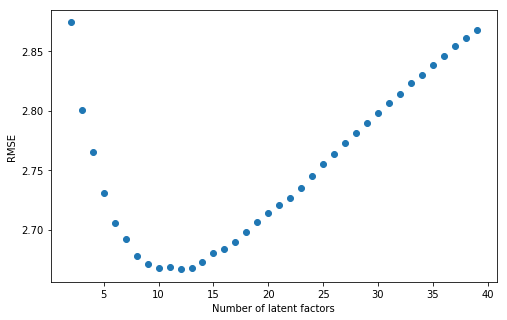

In [146]:
plt.figure(figsize=(8,5))
plt.plot(ks, rmses, "o")
plt.xlabel("Number of latent factors")
plt.ylabel("RMSE")
plt.show()